# Logistic Regression 

We run regression to see which explanatory variables can better predict the presence of heart disease. For each variable, we construct a model, compute $R^{2}$, and append the results to a list. The higher the $R^{2}$ value, the more predictive power the corresponding variable has. 

## Data Cleaning

Read in data

Info on variables:
- `slope_of_peak_exercise_st_segment` (type: `int`): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- `thal` (type: `categorical`): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- `resting_blood_pressure` (type: `int`): resting blood pressure
- `chest_pain_type` (type: `int`): chest pain type (4 values)
- `num_major_vessels` (type: `int`): number of major vessels (0-3) colored by flourosopy
- `fasting_blood_sugar_gt_120_mg_per_dl` (type: `binary`): fasting blood sugar > 120 mg/dl
- `resting_ekg_results` (type: `int`): resting electrocardiographic results (values 0,1,2)
- `serum_cholesterol_mg_per_dl` (type: `int`): serum cholestoral in mg/dl
- `oldpeak_eq_st_depression` (type: `float`): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- `sex` (type: `binary`): 0: female, 1: male
- `age` (type: `int`): age in years
- `max_heart_rate_achieved` (type: `int`): maximum heart rate achieved (beats per minute)
- `exercise_induced_angina` (type: `binary`): exercise-induced chest pain (0: False, 1: True)

In [72]:
# Importing the necessary librariers 
import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import statsmodels.formula.api as smf

from sklearn.preprocessing import scale # center to the mean and component wise scale to unit variance.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.pipeline as skpl # convenient module for calculating PCs and using them in logistic regression
from sklearn.utils import shuffle

In [44]:
train_values = pd.read_csv('data/train_values.csv')
train_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [45]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


Merge the two dfs

In [46]:
train = pd.merge(train_values, train_labels, on="patient_id")
train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Set index to `patient_id`

In [47]:
train = train.set_index('patient_id')
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


## Data Mining
Conduct data mining. First replace `thal` values with numbers. Key:
- `normal`: 0
- `fixed_defect`: 1
- `reversible_defect`: 2

In [49]:
train['thal'] = train['thal'].replace('normal', 0)
train['thal'] = train['thal'].replace('fixed_defect', 1)
train['thal'] = train['thal'].replace('reversible_defect', 2)
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,0,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,0,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,0,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,2,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,2,178,1,0,0,2,270,4.2,1,59,145,0,0


In [7]:
categorical = ['thal', 'fasting_blood_sugar_gt_120_mg_per_dl', 'sex', 'exercise_induced_angina']

In [8]:
t = []
for var in train.columns[:-1]:
    if var in categorical:
        formula = 'heart_disease_present ~ C(' + var + ')'
    else:
        formula = 'heart_disease_present ~ ' + var
    model = smf.ols(formula, data=train)
    results = model.fit()

    t.append((results.rsquared, var))

In [9]:
t.sort(reverse=True)
for r2, name in t:
    print(name, r2)

thal 0.2903502482073912
exercise_induced_angina 0.2012836970474967
num_major_vessels 0.1776779521056978
chest_pain_type 0.17042747392162405
oldpeak_eq_st_depression 0.14663555948498785
max_heart_rate_achieved 0.14088902583806318
slope_of_peak_exercise_st_segment 0.1184901531728666
sex 0.11250720046082952
resting_ekg_results 0.02129655558667054
age 0.01911436391120569
serum_cholesterol_mg_per_dl 0.006364026902311748
resting_blood_pressure 0.00616315049709204
fasting_blood_sugar_gt_120_mg_per_dl 1.1418131993679026e-05


Variables that affect presence of heart disease the most are `thal`, `exercise_induced_angina`, and `num_major_vessels`

## PCR

In this section, we use Principal Components Analysis to improve logistic regression. First, we make a correlation matrix from each feature pair.

TODO:
1. do 80, 20 train test split and find best number of eigenvectors to use for that (highest accuracy). Use to create distribution of accuracy by drawing random 80, 20 splits and finding accuracy. (should we also find best threshold for logistic regression?)
2. clean up section (make copy before)

In [50]:
# Store response variable
y = train['heart_disease_present']

# Prepare data matrix
X = scale(train.drop(['heart_disease_present'], 1).astype(float))

In [67]:
def PCR(X, y, test_size=0.2, shuffle=True):
    # Apply to training data

    # Split into training and test sets (80-20 split)
    # Random state?!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1, shuffle=shuffle)

    # Perform PCA on training data to evaluate test set performance
    pca_train = PCA()
    
    Z_train = pca_train.fit_transform(scale(X_train))
    n = len(Z_train)

    # Go through number of PCs used
    max_accuracy = (0, 0)
    for i in np.arange(1, 14):
        Z_train_reduced = Z_train[:,:i]
        Z_test_reduced = pca_train.transform(scale(X_test))[:,:i]
        # Train regression model on training data
        regr = LogisticRegression(solver='lbfgs')
        regr.fit(Z_train_reduced, y_train)

        # Predict the labels of the test set: y_pred
        y_pred = regr.predict(Z_test_reduced)
        
        temp_accuracy = accuracy_score(y_test, y_pred)
        
        if temp_accuracy > max_accuracy[1]:
            max_accuracy = (i, temp_accuracy)
    return max_accuracy

In [68]:
print(PCR(X, y))

(13, 0.8333333333333334)


In [71]:
num = train.shape[0]

In [73]:
iters = 100
for i in range(iters):
    # randomize rows
    df = shuffle(train)
    # Store response variable
    y = df['heart_disease_present']
    # Prepare data matrix
    X = scale(df.drop(['heart_disease_present'], 1).astype(float))
    print(PCR(X, y))

(1, 0.8888888888888888)
(2, 0.9166666666666666)
(1, 0.8055555555555556)
(5, 0.8611111111111112)
(3, 0.8333333333333334)
(2, 0.8055555555555556)
(6, 0.9166666666666666)
(5, 0.9166666666666666)
(9, 0.8611111111111112)
(4, 0.8333333333333334)
(4, 0.8333333333333334)
(3, 0.8888888888888888)
(7, 0.8611111111111112)
(6, 0.8888888888888888)
(6, 0.9166666666666666)
(11, 0.9166666666666666)
(5, 0.8611111111111112)
(3, 0.8333333333333334)
(8, 0.8888888888888888)
(3, 0.8333333333333334)
(2, 0.8333333333333334)
(1, 0.8333333333333334)
(1, 0.8888888888888888)
(1, 0.7777777777777778)
(2, 0.9444444444444444)
(1, 0.9166666666666666)
(3, 0.9444444444444444)
(7, 0.8888888888888888)
(7, 0.8055555555555556)
(2, 0.8888888888888888)
(12, 0.8055555555555556)
(3, 0.9166666666666666)
(2, 0.8888888888888888)
(8, 0.8333333333333334)
(2, 0.9166666666666666)
(1, 0.8888888888888888)
(1, 0.9166666666666666)
(1, 0.8888888888888888)
(5, 0.8611111111111112)
(2, 0.8333333333333334)
(1, 0.8333333333333334)
(4, 0.94444444

WTF?! What do we do?

In [10]:
corr = train.corr()
print(corr.shape)

(14, 14)


The correlation matrix is a square matrix with length being the number of features, including the dependent variable. 

We create a heatmap of the correlation matrix.

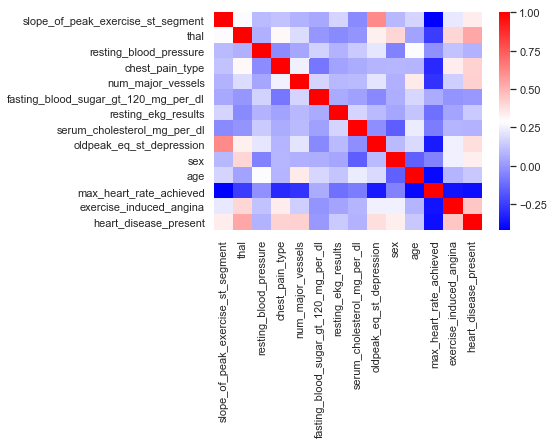

In [11]:
sns.heatmap(corr, cmap = 'bwr')
plt.show()

Red squares off the main diagonal imply multicollinearity. There are a few, but not many, so PCR might not be the best model.  

In [12]:
# Store response variable
y = train['heart_disease_present']

# Prepare data matrix
X = scale(train.drop(['heart_disease_present'], 1).astype(float))
print(X) # independent variables

[[-0.89124111 -0.89495691 -0.19519463 ... -1.05396422  0.93248505
  -0.68074565]
 [ 0.72919727 -0.89495691 -1.25631978 ... -0.08713407  0.38708356
  -0.68074565]
 [-0.89124111 -0.89495691 -0.37204882 ...  2.38365407  0.56888406
   1.46897745]
 ...
 [ 0.72919727  1.17032826 -0.37204882 ...  0.98712164 -0.8400698
   1.46897745]
 [-0.89124111 -0.89495691 -0.43100022 ... -0.7316875   1.15973567
  -0.68074565]
 [-0.89124111 -0.89495691  1.69125009 ... -0.08713407  0.61433418
  -0.68074565]]


In [13]:
# Perform PCA via the sklearn PCA library and generate score matrix, Z
pca = PCA()
Z = pca.fit_transform(X)
Z

array([[-2.16064096e+00,  1.57579641e-01,  2.28332202e-02, ...,
         4.56400794e-01, -2.94083502e-01,  1.04713378e-02],
       [-1.14751585e+00, -1.16875495e-01,  9.82416532e-01, ...,
        -8.14973635e-02,  6.89783107e-01,  9.29679339e-04],
       [ 1.07527110e+00,  1.53509428e+00, -2.83935305e+00, ...,
         4.69418412e-01,  1.88084242e+00,  7.78056395e-01],
       ...,
       [ 1.82650968e+00, -6.18465234e-01, -8.49455033e-02, ...,
        -1.51828742e-01,  7.18316057e-01, -2.48670639e-02],
       [-1.54461653e+00,  2.58736530e-01, -9.32878764e-01, ...,
         9.66246110e-01, -1.91554015e-01,  6.07838084e-02],
       [-1.68349880e+00,  9.89043126e-01, -6.04590589e-02, ...,
        -2.63837974e-02, -5.98720511e-01,  5.28739513e-01]])

In [14]:
# Find and print eigenvalues, prop of variance explained, and cumulative prop explained for PCs
eig_values = pca.explained_variance_
percent_var = pca.explained_variance_ratio_
cum_var = np.cumsum(percent_var)
print("Num Eigenvalues: ", len(eig_values))
print("Eigenvalues: ", eig_values)
print("Prop of variance explained: ", percent_var) # prop of variance explained
print("Cumulative prop explained: ", cum_var) # cumulative

Num Eigenvalues:  13
Eigenvalues:  [2.98974885 1.72516628 1.2851921  1.20511047 1.02578452 0.99483371
 0.73266088 0.72193415 0.67807683 0.56447528 0.45496695 0.38789635
 0.30677933]
Prop of variance explained:  [0.22870301 0.13196785 0.0983117  0.0921858  0.07846813 0.07610053
 0.05604543 0.05522488 0.05186998 0.04317995 0.03480303 0.02967241
 0.02346731]
Cumulative prop explained:  [0.22870301 0.36067086 0.45898256 0.55116836 0.62963649 0.70573702
 0.76178245 0.81700733 0.8688773  0.91205725 0.94686028 0.97653269
 1.        ]


In [15]:
# Run PCR with disease/ no disease as dependent variable

# Perform 5-fold cross-validation to see how it influences the MSE
n = len(Z) # number of samples

# KFold provides train/test indices to split data in train/test sets. 
# Split dataset into k consecutive folds with shuffling
kf_5 = KFold(5, shuffle=True, random_state=1)

# Set up ordinary least squares logistic regression 
regr = LogisticRegression(solver='lbfgs')

# Array to store mean squared errors (MSE)
mse = []

# Calculate average MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y.ravel(), cv=kf_5, scoring='neg_mean_squared_error').mean()
mse.append(score)

In [16]:
# Calculate average MSE using cross-validation for the 13 principle components
# adding one more component with each iteration
for i in np.arange(1, 14):
    # Find average MSE and add to mse array
    score = -1*cross_val_score(regr, Z[:,:i], y.ravel(), cv=kf_5, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
    # Find accuracy and print
    score2 = cross_val_score(regr, Z[:,:i], y.ravel(), cv=kf_5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))

Accuracy: 0.81 (+/- 0.17)
Accuracy: 0.82 (+/- 0.18)
Accuracy: 0.85 (+/- 0.23)
Accuracy: 0.84 (+/- 0.22)
Accuracy: 0.84 (+/- 0.26)
Accuracy: 0.82 (+/- 0.25)
Accuracy: 0.83 (+/- 0.21)
Accuracy: 0.81 (+/- 0.21)
Accuracy: 0.83 (+/- 0.19)
Accuracy: 0.83 (+/- 0.21)
Accuracy: 0.82 (+/- 0.22)
Accuracy: 0.81 (+/- 0.24)
Accuracy: 0.81 (+/- 0.24)


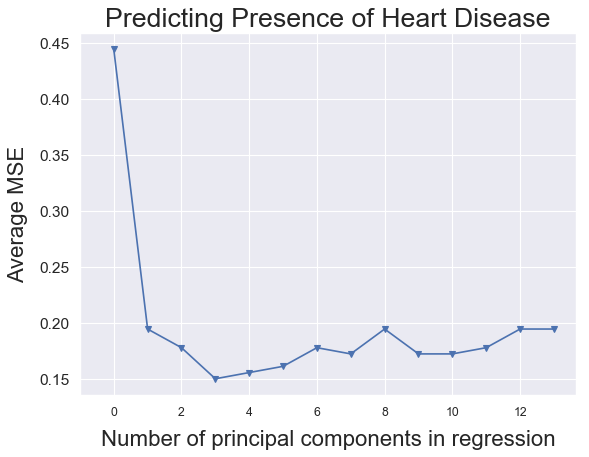

In [17]:
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Presence of Heart Disease', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(left=-1)
plt.show()

Smallest cross validation error seems to occur after 3 PCs used

In [18]:
# Apply to training data

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Perform PCA on training data to evaluate test set performance
pca_train = PCA()

Accuracy: 0.83 (+/- 0.17)
Accuracy: 0.83 (+/- 0.17)
Accuracy: 0.83 (+/- 0.15)
Accuracy: 0.86 (+/- 0.14)
Accuracy: 0.85 (+/- 0.14)
Accuracy: 0.85 (+/- 0.14)
Accuracy: 0.85 (+/- 0.15)
Accuracy: 0.81 (+/- 0.22)
Accuracy: 0.81 (+/- 0.22)
Accuracy: 0.82 (+/- 0.21)
Accuracy: 0.82 (+/- 0.18)
Accuracy: 0.83 (+/- 0.17)
Accuracy: 0.82 (+/- 0.20)


C:\ProgramData\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


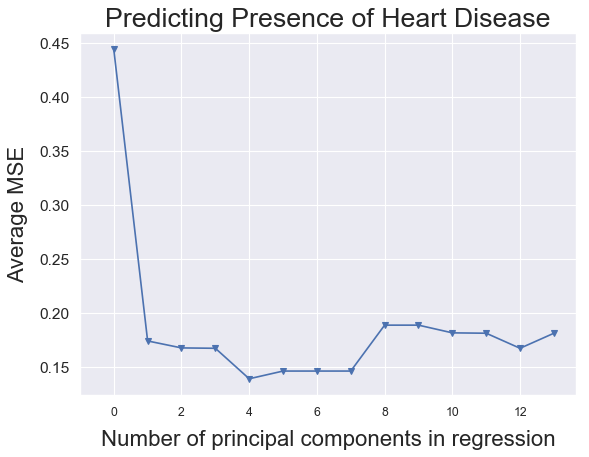

In [42]:
# Verify number of PCs with smallest MSE on X_train
Z_train = pca_train.fit_transform(scale(X_train))
n = len(Z_train)

# Prepare 3-fold CV, with shuffle
kf_3 = KFold(7, shuffle=True, random_state=1)
mse = []

# Calculate average MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train.ravel(), cv=kf_3, scoring='neg_mean_squared_error').mean()
mse.append(score)

# Calculate average MSEs using CV for the 30 principle components, adding one component at the time.
for i in np.arange(1, 14):
    score = -1*cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_3, scoring='neg_mean_squared_error').mean()
    score2 = cross_val_score(regr, Z_train[:,:i], y_train.ravel(), cv=kf_3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))
    mse.append(score)
    
# Plot average MSEs against the number of principal components
fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='w')
plt.plot(mse, '-v')
plt.xlabel('Number of principal components in regression', fontsize=20, labelpad=10)
plt.ylabel('Average MSE', fontsize=20, labelpad=10)
plt.title('Predicting Presence of Heart Disease', fontsize=24)
plt.yticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=-1)
plt.show()

One of the smallest cross validation error still occurs when 3 PCs used

In [20]:
# Apply to test data

# Dimensionally reduce training data using 1st 3 PCs
Z_train_reduced = Z_train[:,:3]
# Dimensionally reduce test data using 1st 3 PCs obtained from PCA of training data
Z_test_reduced = pca_train.transform(scale(X_test))[:,:3]

# Train regression model on training data
regr = LogisticRegression(solver='lbfgs')
regr.fit(Z_train_reduced, y_train)

# Use model to predict values from test data
pred = regr.predict(Z_test_reduced)
mean_squared_error(y_test, pred)

0.19444444444444445

In [21]:
# Test if model useful with leave one out cross validation
predMalignantRight = 0 #create count variables
predMalignantWrong = 0
predBenignRight = 0
predBenignWrong = 0

pred = np.asarray(pred)
y_test = np.asarray(y_test)

for i in range(0, len(y_test)):
    testy = y_test[i]
    prediction = pred[i]
    if prediction == 1 and testy == 1:
        predMalignantRight += 1
    elif prediction == 1 and testy == 0:
        predMalignantWrong += 1
    elif prediction == 0 and testy == 1:
        predBenignWrong += 1
    else:
        predBenignRight += 1
        
print(predMalignantRight,predMalignantWrong,predBenignRight,predBenignWrong)

13 4 16 3


In [22]:
# Now sensitivity and specificity will be calculated
mr,mw = float(predMalignantRight), float(predMalignantWrong)
bw,br = float(predBenignWrong), float(predBenignRight)
sens = mr/(mr+mw) #calculate sensitivity, or rate of correctly predicting disease
spec = br/(br+bw) #calculate specificity, or rate of correctly predicting no disease
acc = (sens + spec)/2 #calculate balanced accuracy, or average of sensitivty and specificity
mis = (mw+bw)/(mw+bw+mr+br) #calculate misclassification rate

In [23]:
# create series of values, then convert to dataframe to print as table
outputseries = pd.Series([sens,spec,acc,mis],index=['Sensitivity','Specificity','Balanced Accuracy','Misclassification rate'])
outputdf = pd.DataFrame(outputseries)
outputdf.columns = [''] #blank header name
outputdf.head()

,
Sensitivity,0.764706
Specificity,0.842105
Balanced Accuracy,0.803406
Misclassification rate,0.194444


In [24]:
y_new = pd.Series(y.values)

In [25]:
# Leave one out cross validation method and determine number of PCs that
# results in the most accuracy
mis_arr = []
sens_arr = []
spec_arr = []
acc_arr = []

for i in range(1, 14):
    # Run PCR with first i components
    pca_new = PCA(n_components=i)
    logreg = LogisticRegression(solver='lbfgs')#empty model space

    # Create pipeline from pca to logregression space
    pipeline = skpl.Pipeline([('pca', pca_new), ('logistic', logreg)]) 
    
    # Test if model useful with leave one out cross validation
    predMalignantRight = 0 #create count variables
    predMalignantWrong = 0
    predBenignRight = 0
    predBenignWrong = 0
    
    for i in range(0,len(Z)): #run through each row in data set
        trainX = np.delete(X, i, 0) #train model with predictor dataframe, remove single row
        trainy = y_new.drop(i,0) #train model with response array, remove single row
        testX = X[i,:].reshape(1,13) #Removed row will be test predictor
        testy = y_new[i] #Removed value will be test response
        fit = pipeline.fit(trainX, trainy) #fit model
        prediction = pipeline.predict(testX) #test model with left out value
        if prediction == 1 and testy == 1:
            predMalignantRight += 1
        elif prediction == 1 and testy == 0:
            predMalignantWrong += 1
        elif prediction == 0 and testy == 1:
            predBenignWrong += 1
        else:
            predBenignRight += 1
    
    print(predMalignantRight,predMalignantWrong,predBenignRight,predBenignWrong)
    
    # Calculate sensitivity and specificity
    mr,mw = float(predMalignantRight), float(predMalignantWrong)
    bw,br = float(predBenignWrong), float(predBenignRight)
    sens = mr/(mr+mw) #calculate sensitivity, or rate of correctly predicting disease
    spec = br/(br+bw) #calculate specificity, or rate of correctly predicting no disease
    acc = (sens + spec)/2 #calculate balanced accuracy, or average of sensitivty and specificity
    mis = (mw+bw)/(mw+bw+mr+br) #calculate misclassification rate
    
    # Append values to array
    mis_arr.append(mis)
    sens_arr.append(sens)
    spec_arr.append(spec)
    acc_arr.append(acc)

59 13 87 21
65 14 86 15
63 12 88 17
63 12 88 17
63 12 88 17
63 13 87 17
63 14 86 17
63 13 87 17
64 14 86 16
63 14 86 17
63 14 86 17
64 16 84 16
63 14 86 17


In [26]:
minmis_val, minmis_idx = min((val, idx) for (idx, val) in enumerate(mis_arr))
print("Min misclassification rate: ", minmis_val, "with num PCs: ", minmis_idx+1)

Min misclassification rate:  0.16111111111111112 with num PCs:  2


In [27]:
maxsens_val, maxsens_idx = max((val, idx) for (idx, val) in enumerate(sens_arr))
print("Max sensitivity: ", maxsens_val, "with num PCs: ", maxsens_idx+1)

Max sensitivity:  0.84 with num PCs:  5


In [28]:
maxspec_val, maxspec_idx = max((val, idx) for (idx, val) in enumerate(spec_arr))
print("Max specificity: ", maxspec_val, "with num PCs: ", maxspec_idx+1)

Max specificity:  0.8514851485148515 with num PCs:  2


In [29]:
maxacc_val, maxacc_idx = max((val, idx) for (idx, val) in enumerate(acc_arr))
print("Max balanced accuracy: ", maxacc_val, "with num PCs: ", maxacc_idx+1)

Max balanced accuracy:  0.839047619047619 with num PCs:  5
